In [1]:
import kagglehub

path = kagglehub.dataset_download("PriYaa652/processed-rice-in-bd")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/processed-rice-in-bd


Aush: Attempting RGBe to RGB conversion.
BR-28: Attempting RGBe to RGB conversion.
BR-29: Attempting RGBe to RGB conversion.
Beroi: Attempting RGBe to RGB conversion.
Chinigura: Attempting RGBe to RGB conversion.
Ghee Bhog: Attempting RGBe to RGB conversion.
Katari Najir: Attempting RGBe to RGB conversion.
Katari Siddho: Attempting RGBe to RGB conversion.
Miniket: Attempting RGBe to RGB conversion.
Swarna: Attempting RGBe to RGB conversion.


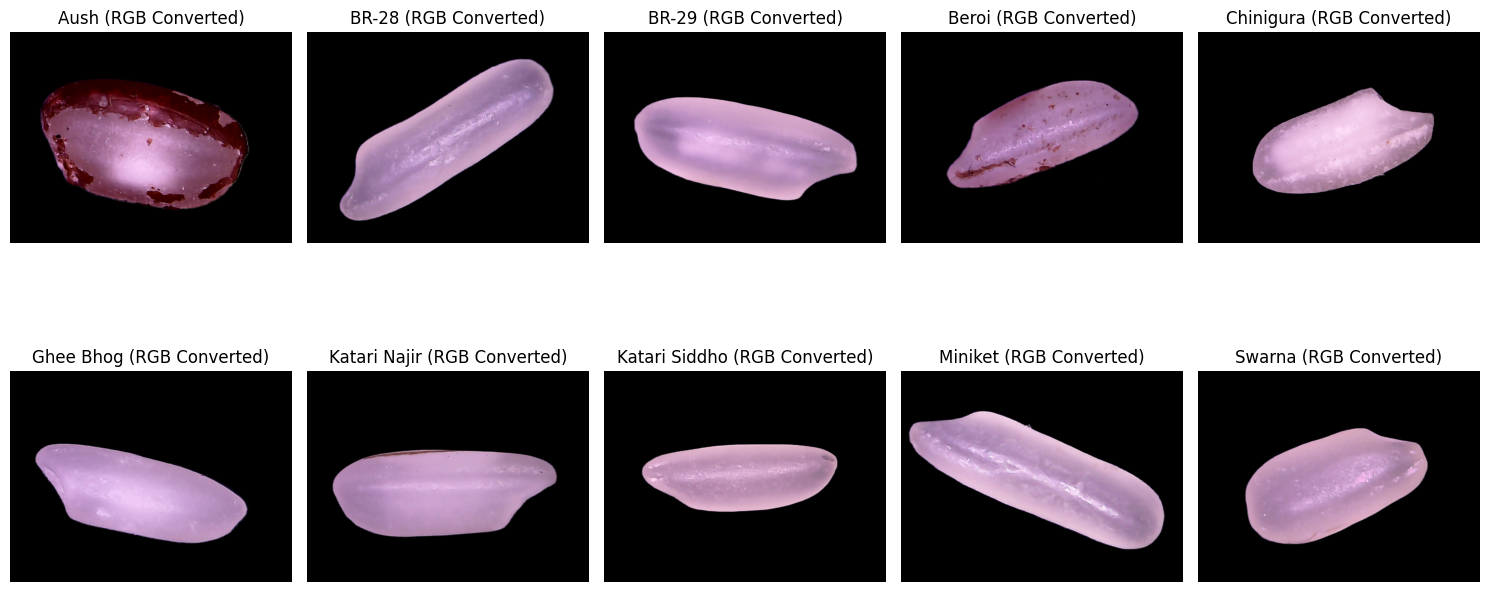

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

#Function: RGBe → RGB (smooth, non-binary) 
def rgbe_to_rgb(img):
    """Converts a 4-channel RGBe image to smooth RGB (0-255)."""
    if img is None or img.ndim != 3 or img.shape[2] != 4:
        print("Warning: Input is not a valid 4-channel image for RGBe conversion.")
        return None

    r, g, b, e = cv2.split(img.astype(np.float32))
    scale = np.exp2(e - 128.0)
    rgb = np.stack([(r / 255) * scale, (g / 255) * scale, (b / 255) * scale], axis=-1)

    # Normalize to 0-255 without binary mapping
    rgb_min, rgb_max = rgb.min(), rgb.max()
    if rgb_max - rgb_min > 0:
        rgb = (rgb - rgb_min) / (rgb_max - rgb_min)
    else:
        rgb = np.zeros_like(rgb)
    rgb = (rgb * 255).astype(np.uint8)

    return rgb

#  Folder paths 
dataset_dir = "/kaggle/input/processed-rice-in-bd/PRBD Microscopic Image of Different Processed Rice/Original_Images"

if not os.path.exists(dataset_dir):
    print(f"Error: Dataset directory not found at {dataset_dir}. Please ensure the dataset is downloaded and extracted correctly.")
else:
    classes = sorted(os.listdir(dataset_dir))

    plt.figure(figsize=(15, 8))

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_dir, cls)

        if not os.path.isdir(class_path):
            print(f"Skipping {cls}: Not a directory.")
            continue

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not image_files:
            print(f"{cls}: No image files found, skipping.")
            continue

        img_path = os.path.join(class_path, image_files[0])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        img_to_display = None
        title_text = cls

        if img is not None and isinstance(img, np.ndarray):
            if img.ndim == 3:  # Color images
                if img.shape[2] == 4:  # RGBe
                    print(f"{cls}: Attempting RGBe to RGB conversion.")
                    img_rgb = rgbe_to_rgb(img)
                    if img_rgb is not None:
                        img_to_display = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
                        title_text += " (RGB Converted)"
                    else:
                        print(f"{cls}: Failed RGBe to RGB conversion.")
                elif img.shape[2] == 3:  # Normal RGB
                    print(f"{cls}: Normal RGB image, using directly.")
                    img_to_display = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
                    title_text += " (Original RGB)"
                else:
                    print(f"{cls}: Unsupported number of channels ({img.shape[2]}), skipping.")
            elif img.ndim == 2:  # Grayscale
                print(f"{cls}: Grayscale image, skipping for visualization.")
            else:
                print(f"{cls}: Unsupported number of dimensions ({img.ndim}), skipping.")
        else:
            print(f"{cls}: Could not load image at {img_path} or it is not a valid numpy array, skipping.")

        # Plotting
        plt.subplot(2, (len(classes) + 1) // 2, i + 1)
        if img_to_display is not None:
            plt.imshow(img_to_display)
            plt.title(title_text)
        else:
            plt.text(0.5, 0.5, "Image Skipped", horizontalalignment='center', verticalalignment='center')
            plt.title(title_text + " (Skipped)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [5]:
import os
import shutil
import numpy as np
import time

dataset_dir = "/kaggle/input/processed-rice-in-bd/PRBD Microscopic Image of Different Processed Rice/Original_Images"
split_base_dir = '/kaggle/working/split_data'


if os.path.exists(split_base_dir):
    shutil.rmtree(split_base_dir)
    time.sleep(1)


classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
splits = ['train', 'val', 'test']

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(split_base_dir, split, cls), exist_ok=True)

# Perform split (10:90, 10% val of 10%)
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    images = sorted(os.listdir(class_dir))
    np.random.shuffle(images)
    total = len(images)

    # Split calculation
    train_val_count = int(total * 0.1)      # 10% → Train + Val
    val_count = int(train_val_count * 0.1)  # 10% of 10% → Validation
    train_count = train_val_count - val_count
    test_count = total - train_val_count     # 90% → Test

    print(f"\nClass: {cls}")
    print(f"Total: {total}, Train: {train_count}, Val: {val_count}, Test: {test_count}")

    # Split the images
    train_val_images = images[:train_val_count]
    test_images = images[train_val_count:]
    val_images = train_val_images[:val_count]
    train_images = train_val_images[val_count:]

    split_images = {'train': train_images, 'val': val_images, 'test': test_images}

    # Copy files to new folders
    for split in splits:
        for img_name in split_images[split]:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_base_dir, split, cls, img_name)
            shutil.copy(src, dst)


print("\n=== Final Split Summary ===\n")
for split in splits:
    print(f"--- {split.upper()} ---")
    for cls in classes:
        split_cls_dir = os.path.join(split_base_dir, split, cls)
        count = len(os.listdir(split_cls_dir))
        print(f"{cls}: {count}")
    print()



Class: Swarna
Total: 200, Train: 18, Val: 2, Test: 180

Class: Katari Siddho
Total: 200, Train: 18, Val: 2, Test: 180

Class: Beroi
Total: 200, Train: 18, Val: 2, Test: 180

Class: BR-29
Total: 200, Train: 18, Val: 2, Test: 180

Class: Katari Najir
Total: 200, Train: 18, Val: 2, Test: 180

Class: Miniket
Total: 200, Train: 18, Val: 2, Test: 180

Class: Chinigura
Total: 200, Train: 18, Val: 2, Test: 180

Class: Ghee Bhog
Total: 200, Train: 18, Val: 2, Test: 180

Class: BR-28
Total: 200, Train: 18, Val: 2, Test: 180

Class: Aush
Total: 200, Train: 18, Val: 2, Test: 180

=== Final Split Summary ===

--- TRAIN ---
Swarna: 18
Katari Siddho: 18
Beroi: 18
BR-29: 18
Katari Najir: 18
Miniket: 18
Chinigura: 18
Ghee Bhog: 18
BR-28: 18
Aush: 18

--- VAL ---
Swarna: 2
Katari Siddho: 2
Beroi: 2
BR-29: 2
Katari Najir: 2
Miniket: 2
Chinigura: 2
Ghee Bhog: 2
BR-28: 2
Aush: 2

--- TEST ---
Swarna: 180
Katari Siddho: 180
Beroi: 180
BR-29: 180
Katari Najir: 180
Miniket: 180
Chinigura: 180
Ghee Bhog: 180


Model: NASNetMobile

2025-10-26 19:49:36.858118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761508177.041803      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761508177.096108      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 180 images belonging to 10 classes.
Found 20 images belonging to 10 classes.
Found 1800 images belonging to 10 classes.


I0000 00:00:1761508189.221490      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1761508225.291441     126 service.cc:148] XLA service 0x78049414f0f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761508225.292343     126 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761508229.507820     126 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761508236.481903     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 - 66s - 11s/step - accuracy: 0.1778 - loss: 2.3180 - val_accuracy: 0.5000 - val_loss: 1.7197 - learning_rate: 0.0010
Epoch 2/50
6/6 - 2s - 270ms/step - accuracy: 0.4556 - loss: 1.5361 - val_accuracy: 0.5500 - val_loss: 1.3987 - learning_rate: 0.0010
Epoch 3/50
6/6 - 2s - 269ms/step - accuracy: 0.6389 - loss: 1.0776 - val_accuracy: 0.6000 - val_loss: 1.2496 - learning_rate: 0.0010
Epoch 4/50
6/6 - 2s - 265ms/step - accuracy: 0.7333 - loss: 0.8624 - val_accuracy: 0.6000 - val_loss: 1.2130 - learning_rate: 0.0010
Epoch 5/50
6/6 - 2s - 268ms/step - accuracy: 0.7667 - loss: 0.7539 - val_accuracy: 0.6000 - val_loss: 1.2460 - learning_rate: 0.0010
Epoch 6/50
6/6 - 2s - 271ms/step - accuracy: 0.7944 - loss: 0.7041 - val_accuracy: 0.6000 - val_loss: 1.1952 - learning_rate: 0.0010
Epoch 7/50
6/6 - 2s - 270ms/step - accuracy: 0.8056 - loss: 0.6047 - val_accuracy: 0.7000 - val_loss: 1.2121 - learning_rate: 0.0010
Epoch 8/50
6/6 - 2s - 271ms/step - accuracy: 0.8500 - loss: 0.5361 - val_accuracy

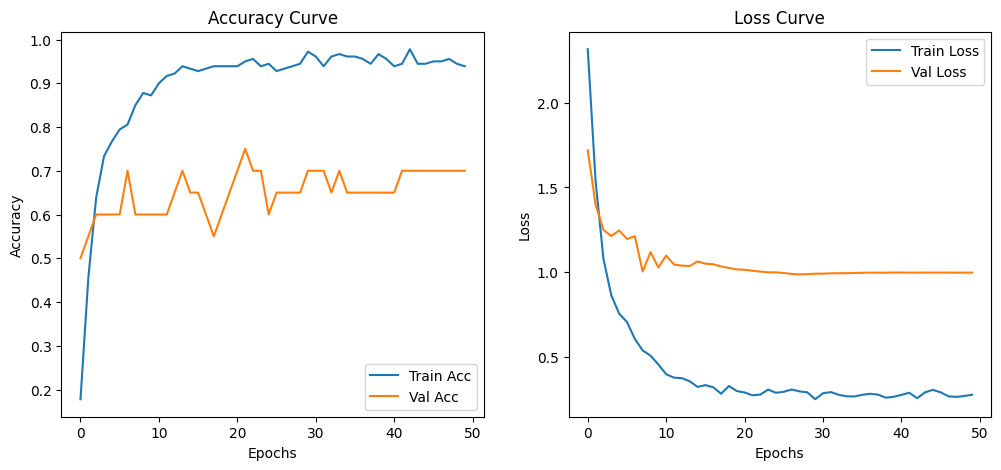


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9595    0.9222    0.9405       180
Katari Siddho     0.6489    0.6778    0.6630       180
        Beroi     0.6919    0.7111    0.7014       180
        BR-29     0.9198    0.9556    0.9373       180
 Katari Najir     0.8958    0.9556    0.9247       180
      Miniket     0.7725    0.8111    0.7913       180
    Chinigura     0.7517    0.6222    0.6809       180
    Ghee Bhog     0.5944    0.5944    0.5944       180
        BR-28     0.8439    0.8111    0.8272       180
         Aush     0.7609    0.7778    0.7692       180

     accuracy                         0.7839      1800
    macro avg     0.7839    0.7839    0.7830      1800
 weighted avg     0.7839    0.7839    0.7830      1800



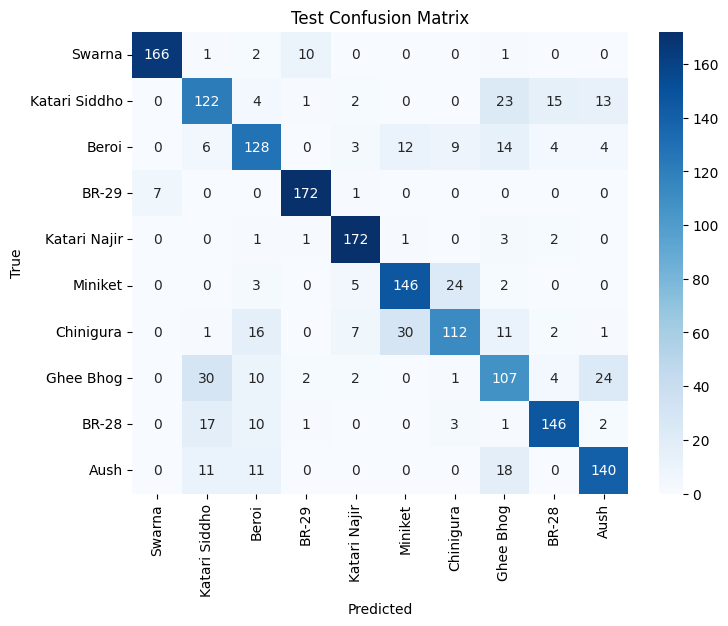

Swarna Accuracy: 0.9222
Katari Siddho Accuracy: 0.6778
Beroi Accuracy: 0.7111
BR-29 Accuracy: 0.9556
Katari Najir Accuracy: 0.9556
Miniket Accuracy: 0.8111
Chinigura Accuracy: 0.6222
Ghee Bhog Accuracy: 0.5944
BR-28 Accuracy: 0.8111
Aush Accuracy: 0.7778
Test AUC: 0.9728
Test PR AUC: 0.8477

Training Time: 144.78 seconds


In [6]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# Paths and parameters

split_base_dir = '/kaggle/working/split_data'
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]


# Data generators
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


# Model: NASNetMobile

def build_nasnetmobile_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = NASNetMobile(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

nasnet_model = build_nasnetmobile_model(num_classes=num_classes)
nasnet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


# Callback (only LR scheduler, no early stop)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


# Training
start_time = time.time()
history = nasnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[reduce_lr],
    verbose=2
)
training_time = time.time() - start_time


# Plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Evaluation function

def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, nasnet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, nasnet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, nasnet_model)

# Reports

print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# AUC & PR
print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTraining Time: {training_time:.2f} seconds")

Macro Precision: 0.7839
Macro Recall: 0.7839
Macro F1-score: 0.7830
Swarna: Precision=0.9595, Recall=0.9222, F1=0.9405
Katari Siddho: Precision=0.6489, Recall=0.6778, F1=0.6630
Beroi: Precision=0.6919, Recall=0.7111, F1=0.7014
BR-29: Precision=0.9198, Recall=0.9556, F1=0.9373
Katari Najir: Precision=0.8958, Recall=0.9556, F1=0.9247
Miniket: Precision=0.7725, Recall=0.8111, F1=0.7913
Chinigura: Precision=0.7517, Recall=0.6222, F1=0.6809
Ghee Bhog: Precision=0.5944, Recall=0.5944, F1=0.5944
BR-28: Precision=0.8439, Recall=0.8111, F1=0.8272
Aush: Precision=0.7609, Recall=0.7778, F1=0.7692


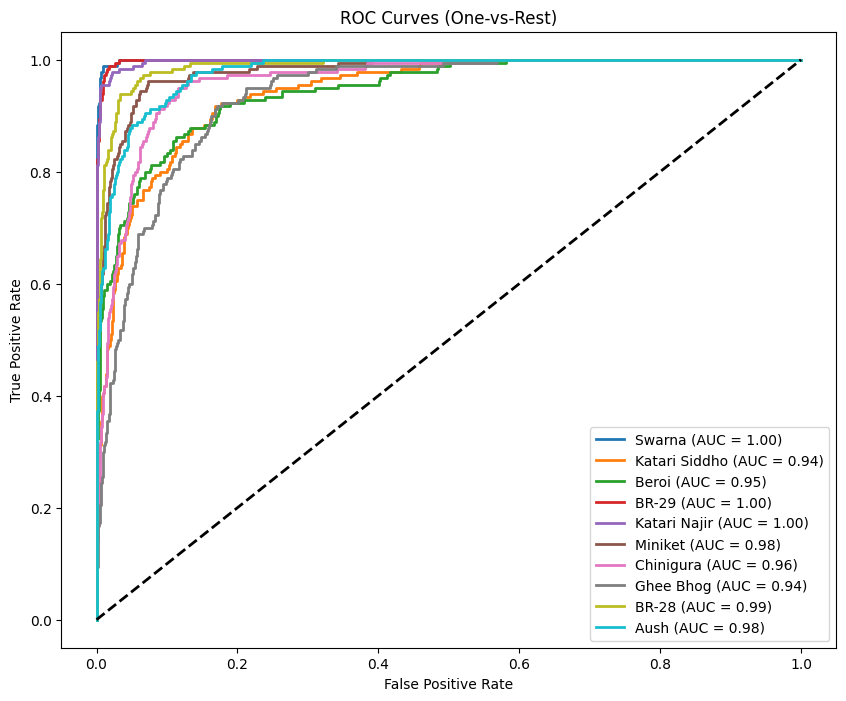

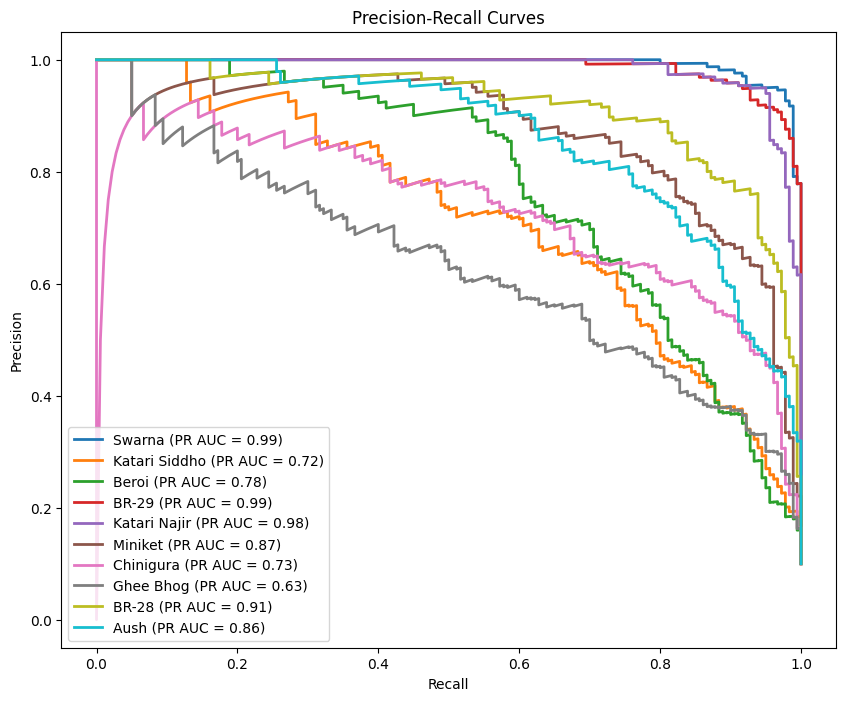

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 41.09 sec
Inference time per sample: 0.022826 sec

Most confused class pairs:
Swarna is most often confused with BR-29 (10 samples)
Katari Siddho is most often confused with Ghee Bhog (23 samples)
Beroi is most often confused with Ghee Bhog (14 samples)
BR-29 is most often confused with Swarna (7 samples)
Katari Najir is most often confused with Ghee Bhog (3 samples)
Miniket is most often confused with Chinigura (24 samples)
Chinigura is most often confused with Miniket (30 samples)
Ghee Bhog is most often confused with Katari Siddho (30 samples)
BR-28 is most often confused with Katari Siddho (17 samples)
Aush is most often confused with Ghee Bhog (18 samples)


In [7]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile


# Assume you already have:
# test_true: true labels (as integers)
# test_pred_prob: predicted probabilities from model.predict
# test_pred: predicted class labels (argmax of test_pred_prob)
# classes: list of class names
# num_classes: total number of classes

# Macro metrics

macro_precision = precision_score(test_true, test_pred, average='macro', zero_division=0)
macro_recall = recall_score(test_true, test_pred, average='macro', zero_division=0)
macro_f1 = f1_score(test_true, test_pred, average='macro', zero_division=0)

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Per-class metrics

per_class_precision = precision_score(test_true, test_pred, average=None, zero_division=0)
per_class_recall = recall_score(test_true, test_pred, average=None, zero_division=0)
per_class_f1 = f1_score(test_true, test_pred, average=None, zero_division=0)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# ROC–AUC curves (One-vs-Rest)

y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curves

plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# Inference time per sample

nasnet_model = NASNetMobile(weights='imagenet', include_top=False)  # dummy, replace with your trained model
start_infer = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)  # test_gen = your test generator
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# Most confused class pairs

cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [8]:
start_test = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

Inference Time per sample: 0.007578 seconds


In [9]:
# Calculate and print the number of parameters
total_params = nasnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 4,269,716
Trainable Parameters: 4,232,978
Non-Trainable Parameters: 36,738


ConvNeXtTiny model

Found 170 images belonging to 10 classes.
Found 10 images belonging to 10 classes.
Found 1800 images belonging to 10 classes.
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
6/6 - 28s - 5s/step - accuracy: 0.1588 - loss: 2.4925 - val_accuracy: 0.2000 - val_loss: 2.0292 - learning_rate: 0.0010
Epoch 2/50
6/6 - 4s - 651ms/step - accuracy: 0.3000 - loss: 1.9401 - val_accuracy: 0.4000 - val_loss: 1.8031 - learning_rate: 0.0010
Epoch 3/50
6/6 - 4s - 654ms/step - accuracy: 0.4588 - loss: 1.6184 - val_accuracy: 0.6000 - val_loss: 1.4333 - learning_rate: 0.0010
Epoch 4/50
6/6 - 3s - 555ms/step - accuracy: 0.5353 - loss: 1.4650 - val_accuracy: 0.6000 - val_loss: 1.1829 - learning_rate: 0.0010
Epoch 5/50
6/6 - 4s - 636ms/step - accuracy: 0.5765 - loss: 1.3094 - val_accuracy: 0.8000 - val_loss: 1.1337 - learning_rate: 0.0010
Epoch 6/50
6/6 - 3s - 560ms/step - accuracy: 0.6118 - loss: 1.1840 - val_accuracy: 0.7000 - val_loss: 0.8789 - learning_rate: 0.0010
Epoch 7/50
6/6 - 3s - 535ms/step - accuracy: 0.6941 - loss: 1.0668 - val_accuracy: 0.7000 - val_loss: 0.9513 - learning_rate: 0.0010
Epoch 8/50
6/6 - 3s - 539ms/step - accuracy: 0.6471 - loss: 1.0823 - va

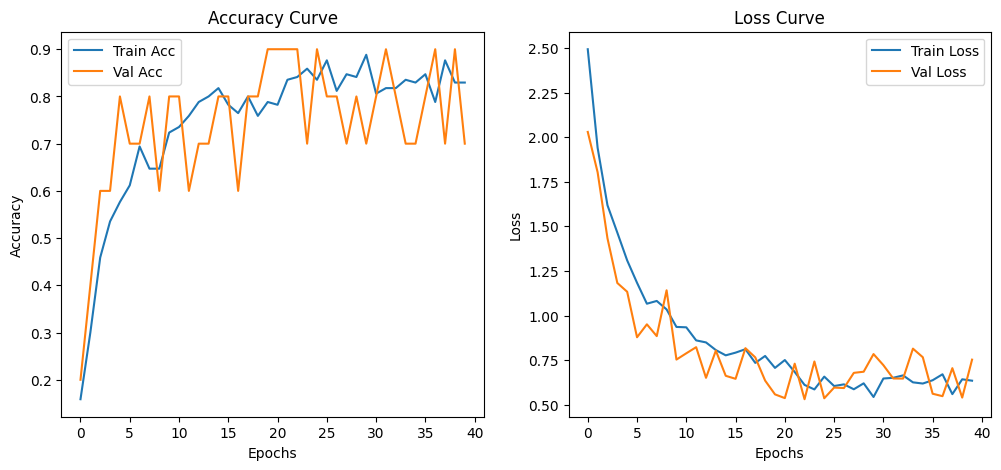


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9884    0.9500    0.9688       180
Katari Siddho     0.6398    0.5722    0.6041       180
        Beroi     0.7986    0.6389    0.7099       180
        BR-29     0.9316    0.9833    0.9568       180
 Katari Najir     0.9721    0.9667    0.9694       180
      Miniket     0.6885    0.9333    0.7925       180
    Chinigura     0.9306    0.3722    0.5317       180
    Ghee Bhog     0.5709    0.9389    0.7101       180
        BR-28     0.8211    0.8667    0.8432       180
         Aush     0.8212    0.6889    0.7492       180

     accuracy                         0.7911      1800
    macro avg     0.8163    0.7911    0.7836      1800
 weighted avg     0.8163    0.7911    0.7836      1800



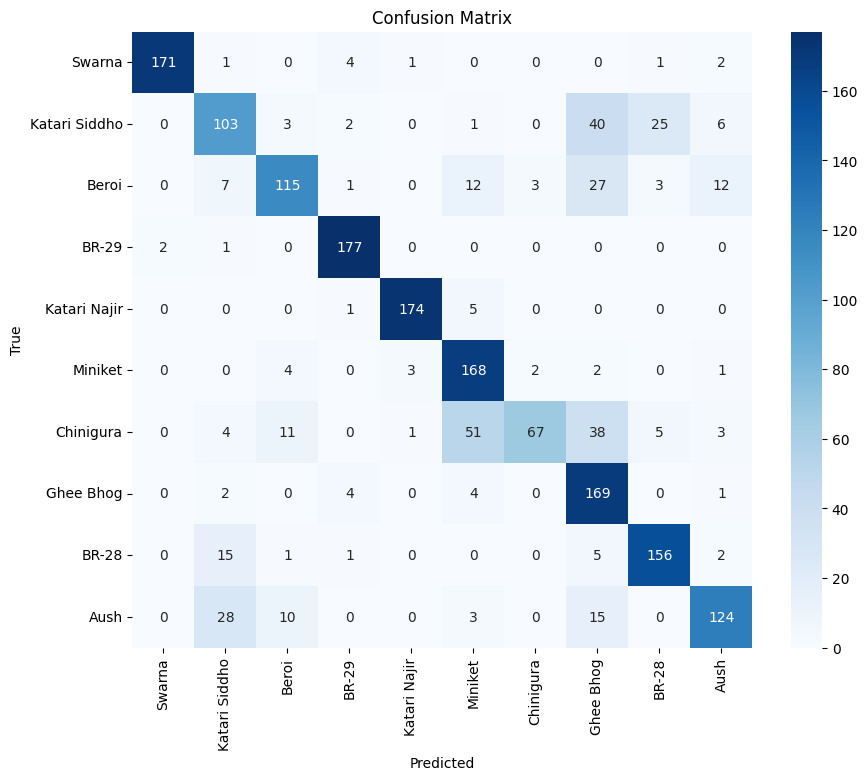

Swarna Accuracy: 0.9500
Katari Siddho Accuracy: 0.5722
Beroi Accuracy: 0.6389
BR-29 Accuracy: 0.9833
Katari Najir Accuracy: 0.9667
Miniket Accuracy: 0.9333
Chinigura Accuracy: 0.3722
Ghee Bhog Accuracy: 0.9389
BR-28 Accuracy: 0.8667
Aush Accuracy: 0.6889
Test AUC: 0.9819
Test PR AUC: 0.8932

Total Training Time: 126.53 seconds


In [11]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns


# Paths and parameters

dataset_dir = "/kaggle/input/processed-rice-in-bd/PRBD Microscopic Image of Different Processed Rice/Original_Images"
split_base_dir = '/kaggle/working/split_data'
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# Data Generators with Augmentation

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    validation_split=0.1  # 10% validation from 20% train+val
)

train_gen = train_datagen.flow_from_directory(
    split_base_dir+'/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    split_base_dir+'/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory(
    split_base_dir+'/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


# Compute class weights

train_labels = train_gen.classes
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

# Build ConvNeXtTiny model

def build_convnext_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ConvNeXtTiny(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze backbone initially
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

convnext_model = build_convnext_model(num_classes=num_classes)
convnext_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Callbacks

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_convnext_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')


# Training (Frozen backbone) - 50 epochs

start_time = time.time()
history = convnext_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,   # 50 epochs frozen
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2
)
training_time = time.time() - start_time
# Fine-tuning (last 20 layers)

convnext_model.trainable = True
for layer in convnext_model.layers[:-20]:
    layer.trainable = False

convnext_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = convnext_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,   # fine-tuning for 10 epochs
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2
)

# Plot training curves

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_ft.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + history_ft.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_ft.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, convnext_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, convnext_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, convnext_model)

print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTotal Training Time: {training_time:.2f} seconds")


Macro Precision: 0.8163
Macro Recall: 0.7911
Macro F1-score: 0.7836
Swarna: Precision=0.9884, Recall=0.9500, F1=0.9688
Katari Siddho: Precision=0.6398, Recall=0.5722, F1=0.6041
Beroi: Precision=0.7986, Recall=0.6389, F1=0.7099
BR-29: Precision=0.9316, Recall=0.9833, F1=0.9568
Katari Najir: Precision=0.9721, Recall=0.9667, F1=0.9694
Miniket: Precision=0.6885, Recall=0.9333, F1=0.7925
Chinigura: Precision=0.9306, Recall=0.3722, F1=0.5317
Ghee Bhog: Precision=0.5709, Recall=0.9389, F1=0.7101
BR-28: Precision=0.8211, Recall=0.8667, F1=0.8432
Aush: Precision=0.8212, Recall=0.6889, F1=0.7492


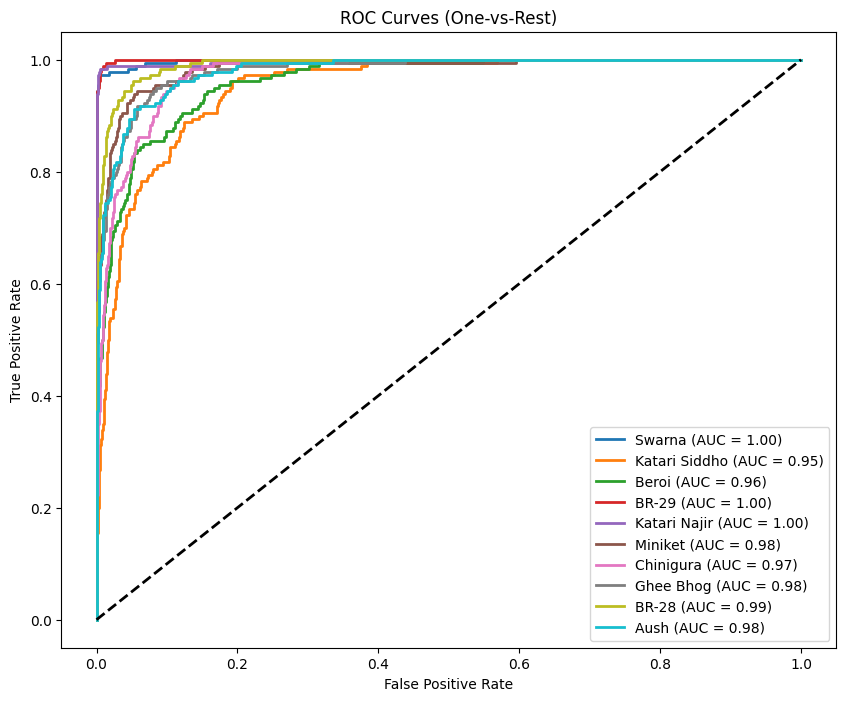

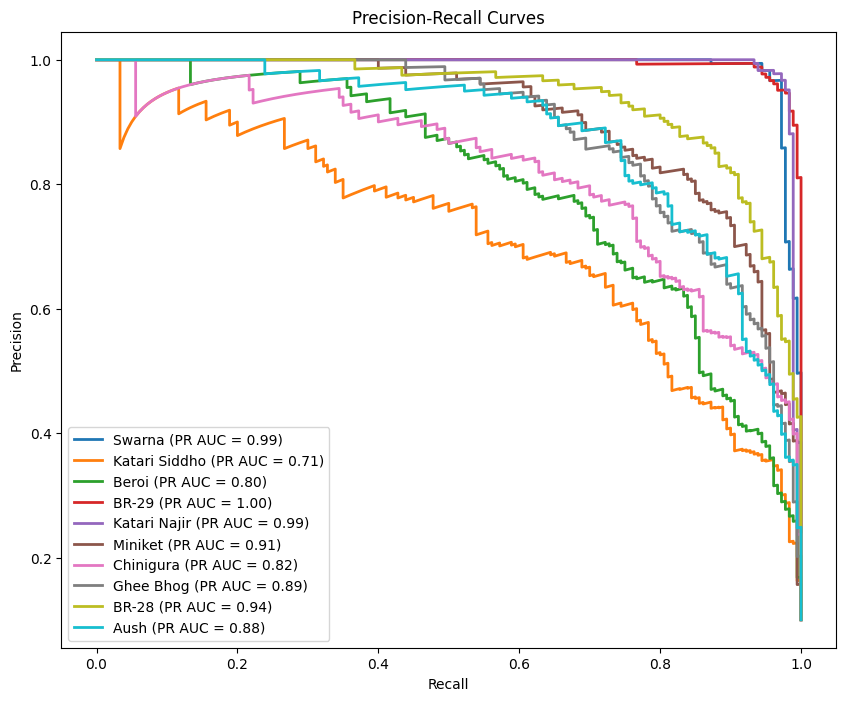


Most confused class pairs:
Swarna is most often confused with BR-29 (4 samples)
Katari Siddho is most often confused with Ghee Bhog (40 samples)
Beroi is most often confused with Ghee Bhog (27 samples)
BR-29 is most often confused with Swarna (2 samples)
Katari Najir is most often confused with Miniket (5 samples)
Miniket is most often confused with Beroi (4 samples)
Chinigura is most often confused with Miniket (51 samples)
Ghee Bhog is most often confused with BR-29 (4 samples)
BR-28 is most often confused with Katari Siddho (15 samples)
Aush is most often confused with Katari Siddho (28 samples)


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import time
import matplotlib.pyplot as plt


# Precision, Recall, F1-score

macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Per-class scores
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# ROC–AUC curves (One-vs-Rest)

y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# PR curves

plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# Failure modes: most confused class pairs

cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [13]:
start_test = time.time()
_ = convnext_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.011346 seconds


In [14]:
# Calculate and print the number of parameters
total_params = convnext_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 28,218,986
Trainable Parameters: 4,232,978
Non-Trainable Parameters: 36,738


 InceptionV3 model

Found 180 images belonging to 10 classes.
Found 20 images belonging to 10 classes.
Found 1800 images belonging to 10 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
6/6 - 38s - 6s/step - accuracy: 0.2056 - loss: 2.6681 - val_accuracy: 0.2500 - val_loss: 1.9182 - learning_rate: 0.0010
Epoch 2/50
6/6 - 5s - 873ms/step - accuracy: 0.4556 - loss: 1.6432 - val_accuracy: 0.5500 - val_loss: 1.4336 - learning_rate: 0.0010
Epoch 3/50
6/6 - 5s - 871ms/step - accuracy: 0.6000 - loss: 1.2694 - val_accuracy: 0.5500 - val_loss: 1.2317 - learning_rate: 0.0010
Epoch 4/50
6/6 - 5s - 866ms/step - accuracy: 0.6722 - loss: 1.0468 - val_accuracy: 0.5500 - val_loss: 1.1070 - learning_rate: 0.0010
Epoch 5/50
6/6 - 5s - 871ms/step - accuracy: 0.6667 - loss: 0.9744 - val_accuracy: 0.6000 - val_loss: 0.9963 - learning_rate: 0.0010
Epoch 6/50
6/6 - 5s - 858ms/step - accuracy: 0.7278 - loss: 0.8773 - val_accuracy: 0.6500 - val_loss: 0.9403 - learning_rate: 0.0010
Epoch 7/50
6/6 - 5s - 848ms

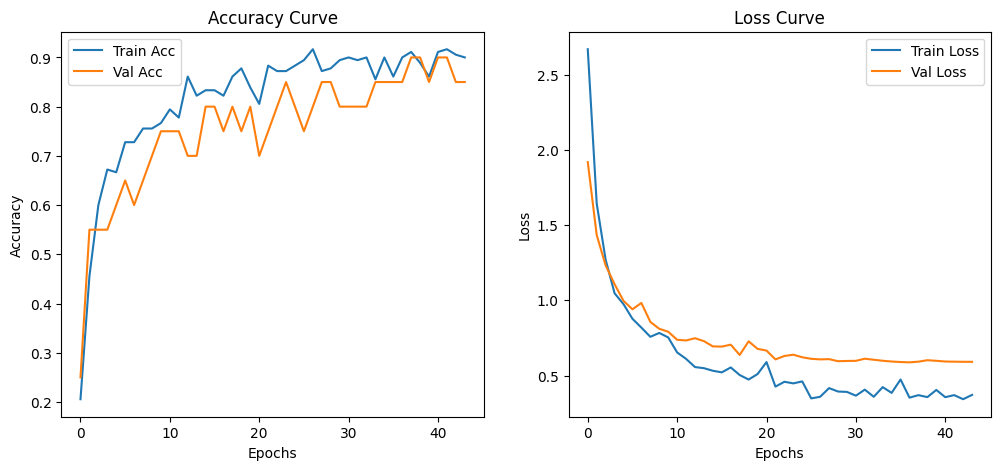


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9247    0.9556    0.9399       180
Katari Siddho     0.5182    0.7111    0.5995       180
        Beroi     0.7865    0.7778    0.7821       180
        BR-29     0.9600    0.9333    0.9465       180
 Katari Najir     0.9290    0.9444    0.9366       180
      Miniket     0.6720    0.9333    0.7814       180
    Chinigura     0.8649    0.5333    0.6598       180
    Ghee Bhog     0.7571    0.5889    0.6625       180
        BR-28     0.8722    0.8722    0.8722       180
         Aush     0.8467    0.7056    0.7697       180

     accuracy                         0.7956      1800
    macro avg     0.8131    0.7956    0.7950      1800
 weighted avg     0.8131    0.7956    0.7950      1800



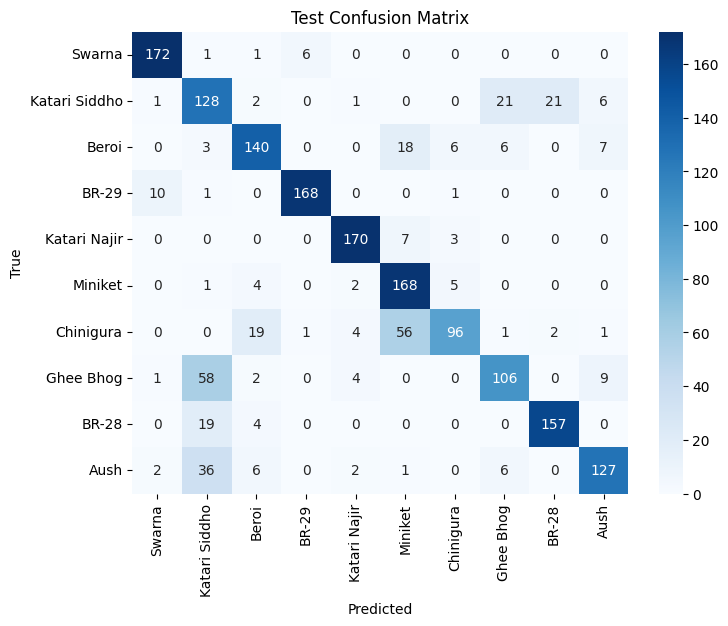

Swarna Accuracy: 0.9556
Katari Siddho Accuracy: 0.7111
Beroi Accuracy: 0.7778
BR-29 Accuracy: 0.9333
Katari Najir Accuracy: 0.9444
Miniket Accuracy: 0.9333
Chinigura Accuracy: 0.5333
Ghee Bhog Accuracy: 0.5889
BR-28 Accuracy: 0.8722
Aush Accuracy: 0.7056
Macro Precision: 0.8131, Macro Recall: 0.7956, Macro F1-score: 0.7950


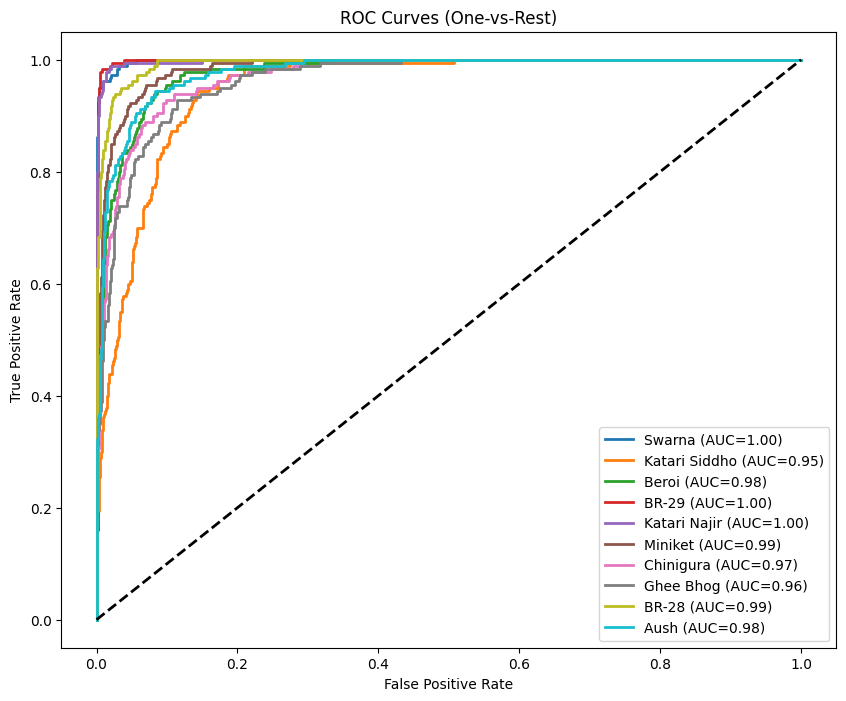

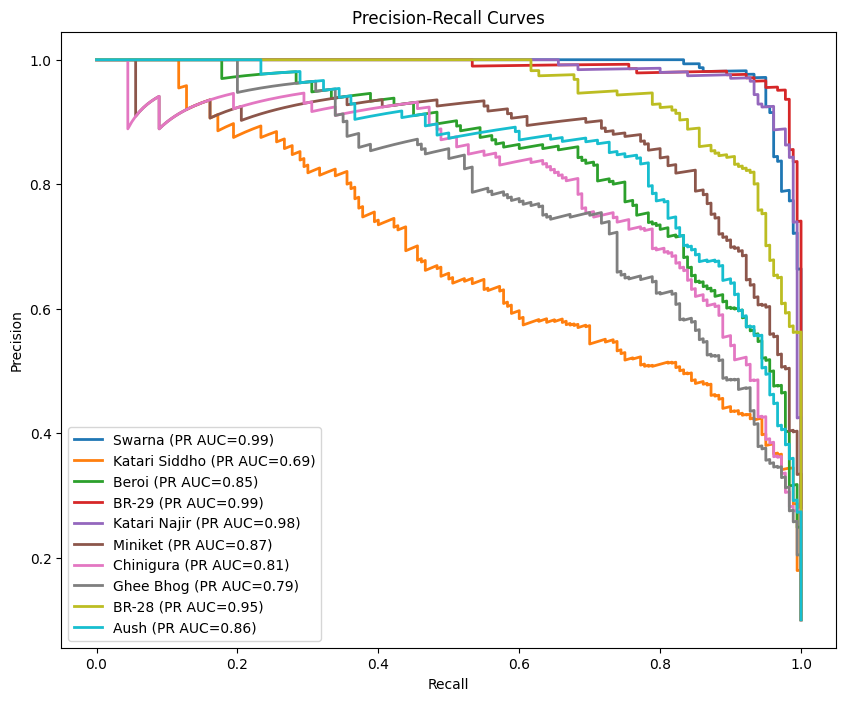


Most confused class pairs:
Swarna is most often confused with BR-29 (6 samples)
Katari Siddho is most often confused with Ghee Bhog (21 samples)
Beroi is most often confused with Miniket (18 samples)
BR-29 is most often confused with Swarna (10 samples)
Katari Najir is most often confused with Miniket (7 samples)
Miniket is most often confused with Chinigura (5 samples)
Chinigura is most often confused with Miniket (56 samples)
Ghee Bhog is most often confused with Katari Siddho (58 samples)
BR-28 is most often confused with Katari Siddho (19 samples)
Aush is most often confused with Katari Siddho (36 samples)


In [17]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Paths and parameters
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/processed-rice-in-bd/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (299, 299)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# Data generators with augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


# Build InceptionV3 model

def build_inception_model(input_shape=(299,299,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone initially
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model, base_model

model, base_model = build_inception_model(num_classes=num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# Plot training curves

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation function

def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, model)

# Classification report & confusion matrix
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))
cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class metrics
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')
print(f"Macro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}, Macro F1-score: {macro_f1:.4f}")

# ROC-AUC & PR Curves
y_true_bin = label_binarize(test_true, classes=range(num_classes))
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC={pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# Most confused classes
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [18]:
# Inference time per sample
start_test = time.time()
_ = model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.014839 seconds


In [19]:
# Model parameter summary
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")


Total Parameters: 22,857,002
Trainable Parameters: 1,054,218
Non-Trainable Parameters: 21,802,784


ResNet50 model

Found 180 images belonging to 10 classes.
Found 20 images belonging to 10 classes.
Found 1800 images belonging to 10 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to best_resnet50_model.h5
12/12 - 40s - 3s/step - accuracy: 0.1611 - loss: 2.3822 - val_accuracy: 0.1000 - val_loss: 2.5185 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.10000
12/12 - 3s - 280ms/step - accuracy: 0.2000 - loss: 2.1818 - val_accuracy: 0.1000 - val_loss: 2.5131 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_accuracy improved from 0.10000 to 0.20000, saving model to best_resnet50_model.h5
12/12 - 4s - 355ms/step - accuracy: 0.2389 - loss: 2.1084 - val_accuracy: 0.2000 - val_loss: 2.4564 - learning_rate: 1.0000e-04
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.20000
12/12 - 3s - 278ms/step - accuracy: 0.3222 - loss: 1.8861 - val_accuracy: 0.2000 - val_loss: 2.4248 - le

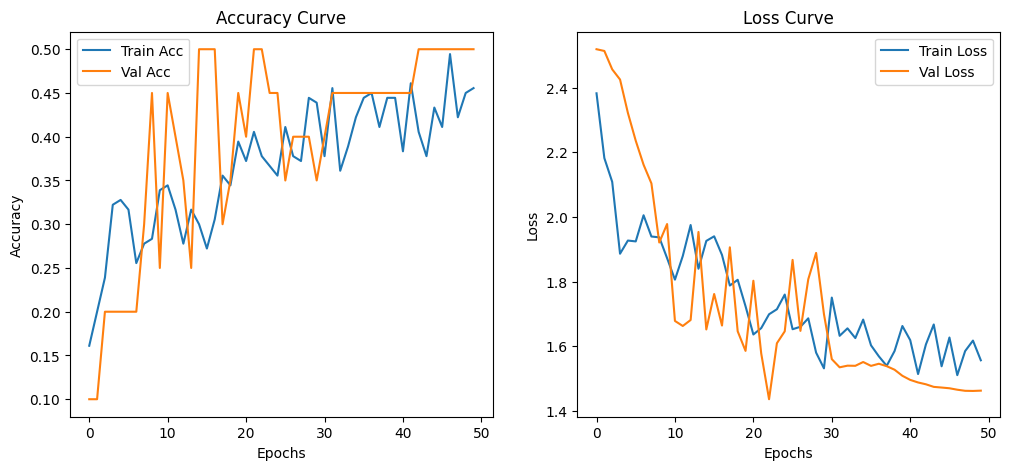


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.7853    0.8333    0.8086       180
Katari Siddho     0.2703    0.1667    0.2062       180
        Beroi     0.5254    0.1722    0.2594       180
        BR-29     0.8521    0.6722    0.7516       180
 Katari Najir     0.9009    0.5556    0.6873       180
      Miniket     0.4375    0.6611    0.5265       180
    Chinigura     0.7236    0.4944    0.5875       180
    Ghee Bhog     0.5924    0.5167    0.5519       180
        BR-28     0.5265    0.8833    0.6598       180
         Aush     0.4458    0.8222    0.5781       180

     accuracy                         0.5778      1800
    macro avg     0.6060    0.5778    0.5617      1800
 weighted avg     0.6060    0.5778    0.5617      1800



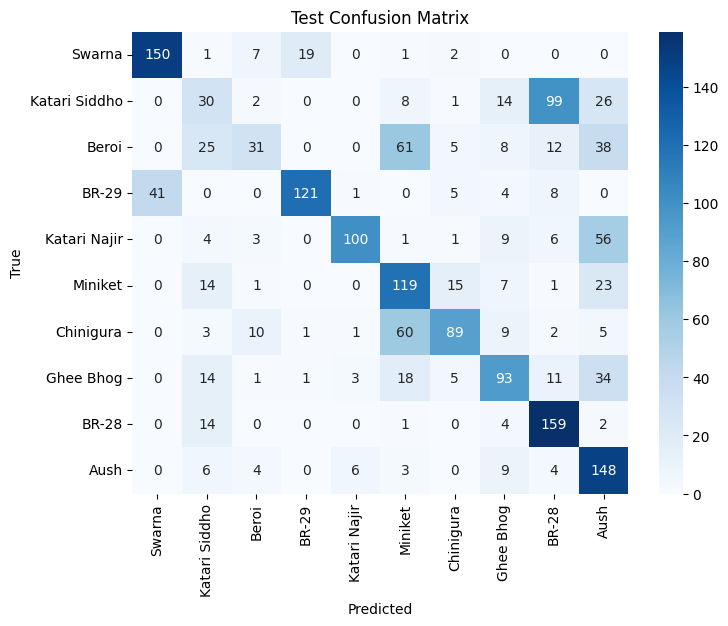

Swarna Accuracy: 0.8333
Katari Siddho Accuracy: 0.1667
Beroi Accuracy: 0.1722
BR-29 Accuracy: 0.6722
Katari Najir Accuracy: 0.5556
Miniket Accuracy: 0.6611
Chinigura Accuracy: 0.4944
Ghee Bhog Accuracy: 0.5167
BR-28 Accuracy: 0.8833
Aush Accuracy: 0.8222

Macro Precision: 0.6060
Macro Recall: 0.5778
Macro F1-score: 0.5617


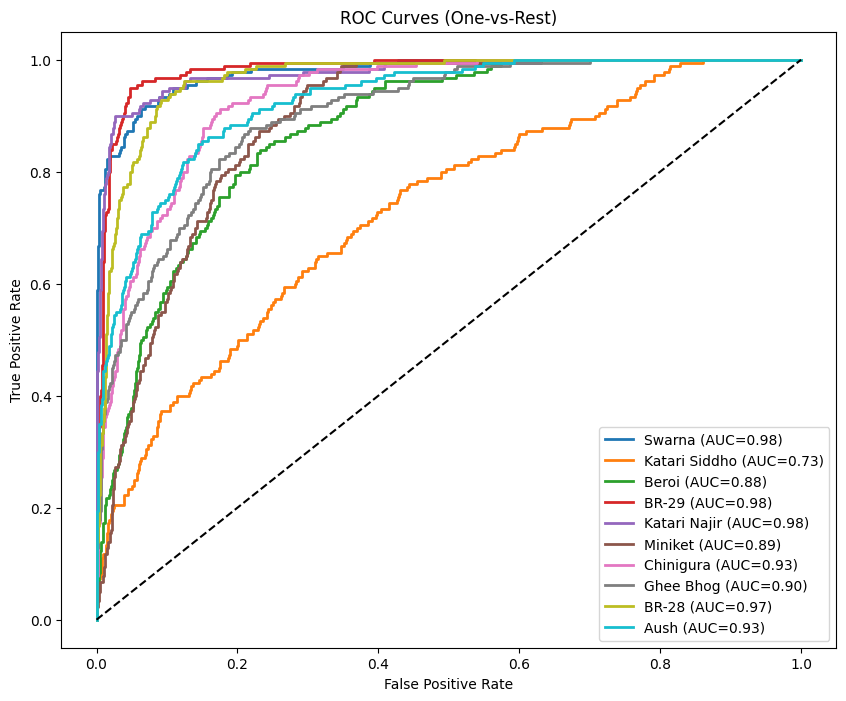

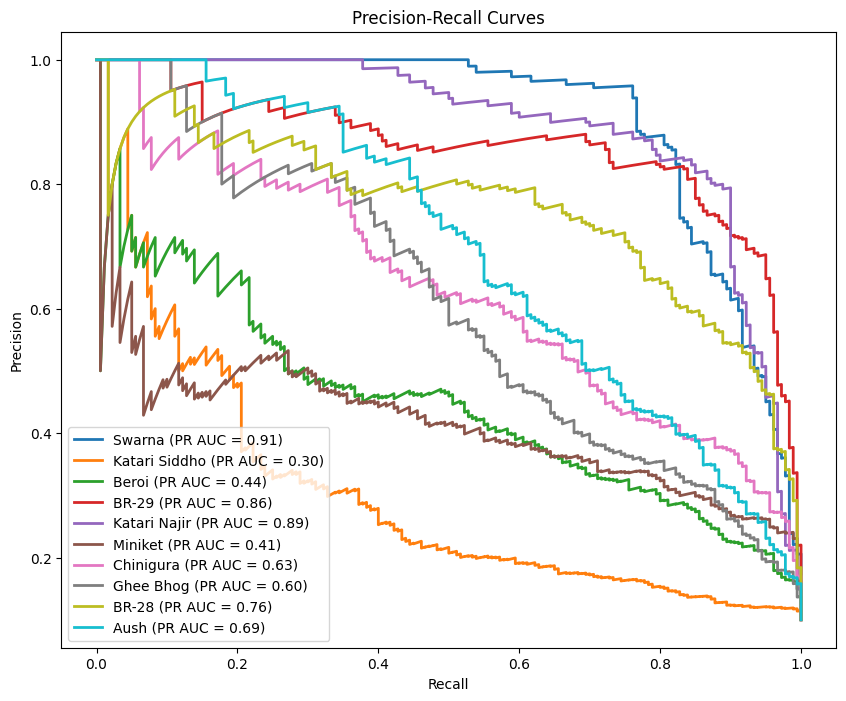


Most confused class pairs:
Swarna is most often confused with BR-29 (19 samples)
Katari Siddho is most often confused with BR-28 (99 samples)
Beroi is most often confused with Miniket (61 samples)
BR-29 is most often confused with Swarna (41 samples)
Katari Najir is most often confused with Aush (56 samples)
Miniket is most often confused with Aush (23 samples)
Chinigura is most often confused with Miniket (60 samples)
Ghee Bhog is most often confused with Aush (34 samples)
BR-28 is most often confused with Katari Siddho (14 samples)
Aush is most often confused with Ghee Bhog (9 samples)


In [20]:
import os
import time
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Paths and parameters
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/processed-rice-in-bd/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (224, 224)
batch_size = 16
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


# Build fine-tuned ResNet50 model
def build_resnet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Fine-tune last 30 layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

resnet_model = build_resnet_model(num_classes=num_classes)

# Compile model

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks

checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

start_time = time.time()

history = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint, reduce_lr],
    verbose=2
)

training_time = time.time() - start_time
print(f"\nTotal Training Time: {training_time/60:.2f} minutes")

# Plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true, y_pred_prob = [], []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, resnet_model)

# Reports

print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Metrics
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"\nMacro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# ROC–AUC Curves
y_true_bin = label_binarize(test_true, classes=range(num_classes))
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# PR Curves
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# Confused class pairs
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [21]:
# Inference time per sample
start_test = time.time()
_ = resnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.012058 seconds


In [22]:
# Inference time per sample
start_test = time.time()
_ = resnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
print(f"Inference time per sample: {inference_time/test_gen.samples:.6f} sec")
print(f"Total inference time for {test_gen.samples} samples: {inference_time:.2f} sec")

# Model parameters summary
total_params = resnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in resnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in resnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Inference time per sample: 0.007212 sec
Total inference time for 1800 samples: 12.98 sec
Total Parameters: 24,641,930
Trainable Parameters: 15,504,394
Non-Trainable Parameters: 9,137,536


 DenseNet121

Found 180 images belonging to 10 classes.
Found 20 images belonging to 10 classes.
Found 1800 images belonging to 10 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
6/6 - 55s - 9s/step - accuracy: 0.1944 - loss: 2.7887 - val_accuracy: 0.2500 - val_loss: 2.0700 - learning_rate: 0.0010
Epoch 2/50
6/6 - 2s - 291ms/step - accuracy: 0.4000 - loss: 1.9471 - val_accuracy: 0.4500 - val_loss: 1.6789 - learning_rate: 0.0010
Epoch 3/50
6/6 - 2s - 293ms/step - accuracy: 0.5611 - loss: 1.3265 - val_accuracy: 0.4000 - val_loss: 1.6656 - learning_rate: 0.0010
Epoch 4/50
6/6 - 2s - 293ms/step - accuracy: 0.6222 - loss: 1.1436 - val_accuracy: 0.4500 - val_loss: 1.3147 - learning_rate: 0.0010
Epoch 5/50
6/6 - 2s - 290ms/step - accuracy: 0.7278 - loss: 0.8630 - val_accuracy: 0.7000 - val_loss: 1.1125 - learning_rate: 0.0010
Epoch 6/50
6/6 - 2s - 292ms/step - accuracy: 0.7389 - loss: 0.7448 - val_accuracy: 0.5000 - val_loss: 1.1096 - learning_rate: 0.0010
Epoch 7/50
6/6 - 2s - 289ms

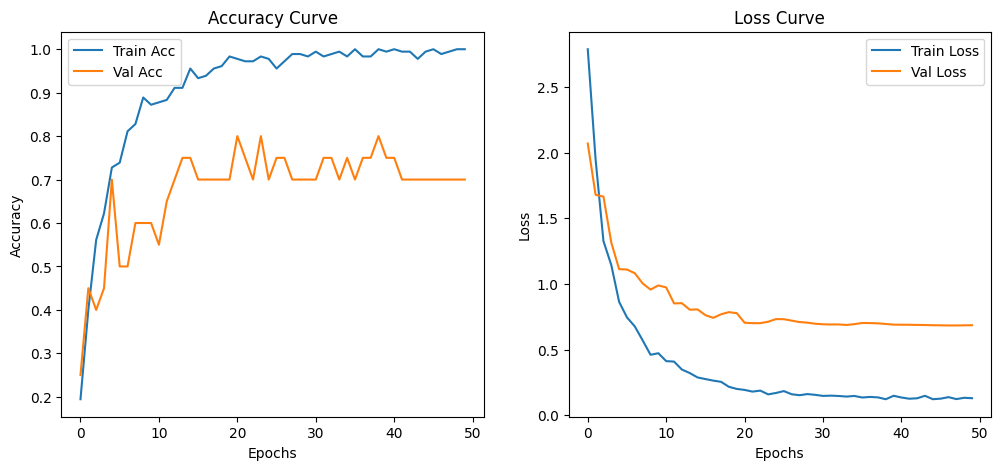


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9667    0.9667    0.9667       180
Katari Siddho     0.7515    0.7056    0.7278       180
        Beroi     0.7273    0.7556    0.7411       180
        BR-29     0.9667    0.9667    0.9667       180
 Katari Najir     0.9617    0.9778    0.9697       180
      Miniket     0.7309    0.9056    0.8089       180
    Chinigura     0.7863    0.5722    0.6624       180
    Ghee Bhog     0.8267    0.9278    0.8743       180
        BR-28     0.9135    0.9389    0.9260       180
         Aush     0.8625    0.7667    0.8118       180

     accuracy                         0.8483      1800
    macro avg     0.8494    0.8483    0.8455      1800
 weighted avg     0.8494    0.8483    0.8455      1800



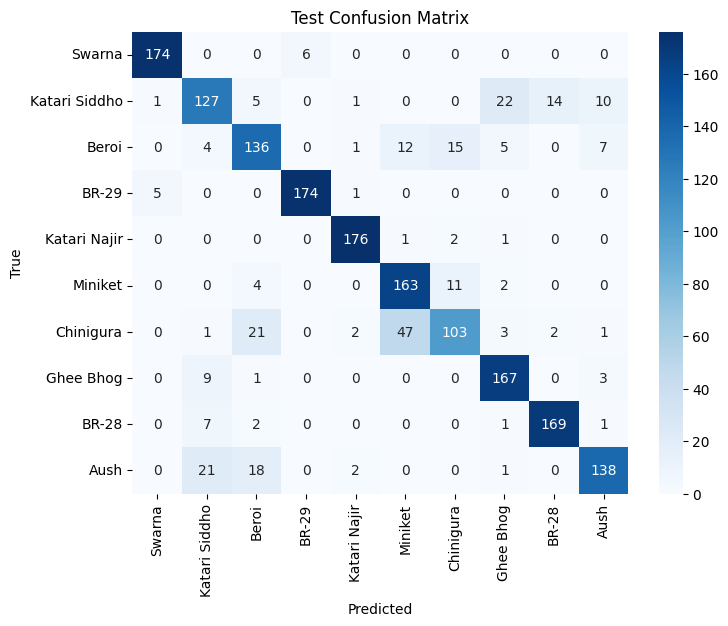

Swarna Accuracy: 0.9667
Katari Siddho Accuracy: 0.7056
Beroi Accuracy: 0.7556
BR-29 Accuracy: 0.9667
Katari Najir Accuracy: 0.9778
Miniket Accuracy: 0.9056
Chinigura Accuracy: 0.5722
Ghee Bhog Accuracy: 0.9278
BR-28 Accuracy: 0.9389
Aush Accuracy: 0.7667


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 34.90 sec
Inference time per sample: 0.019388 sec


In [23]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Paths and parameters

split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/processed-rice-in-bd/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (224, 224)  # DenseNet121 default input
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# Data generators
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model: DenseNet121
def build_densenet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

densenet_model = build_densenet_model(num_classes=num_classes)
densenet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Training

start_time = time.time()
history = densenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,  # increased epochs
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
training_time = time.time() - start_time
print(f"Total training time: {training_time:.2f} sec")

# Plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation function
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, densenet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, densenet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, densenet_model)

# Reports
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# Testing / Inference time per sample
start_infer = time.time()
_ = densenet_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")


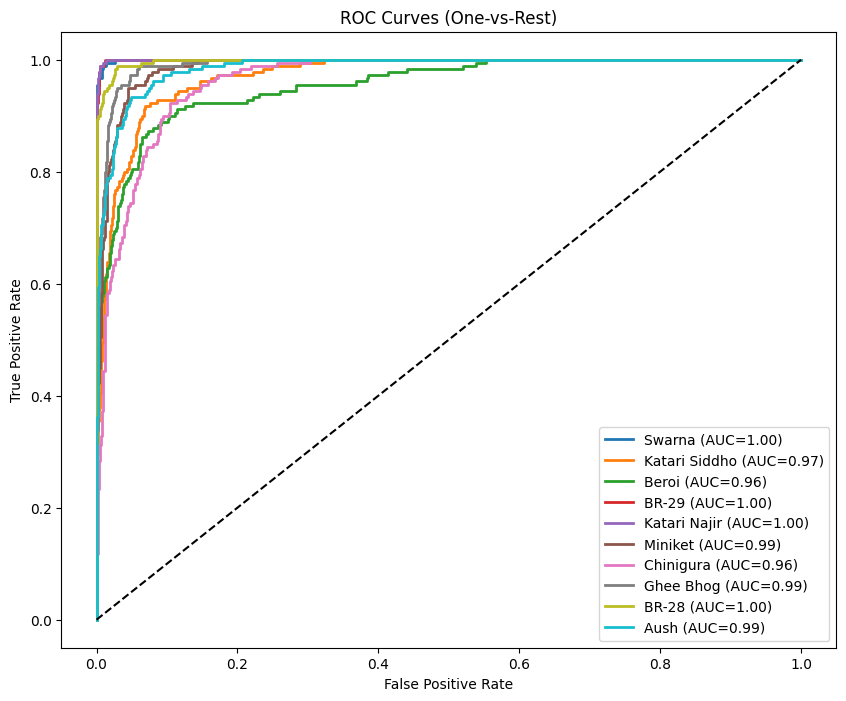

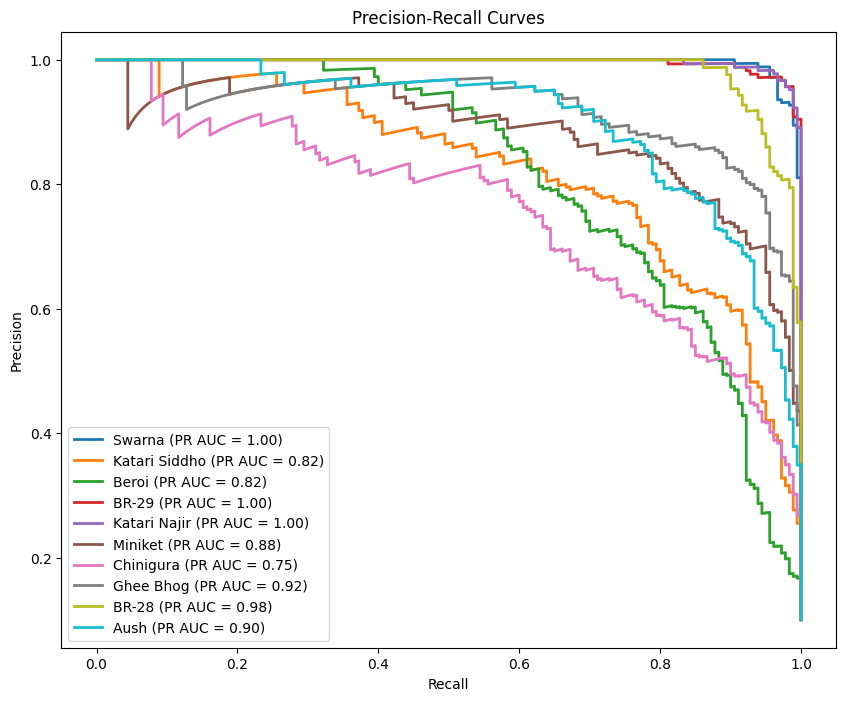


Most confused class pairs:
Swarna is most often confused with BR-29 (6 samples)
Katari Siddho is most often confused with Ghee Bhog (22 samples)
Beroi is most often confused with Chinigura (15 samples)
BR-29 is most often confused with Swarna (5 samples)
Katari Najir is most often confused with Chinigura (2 samples)
Miniket is most often confused with Chinigura (11 samples)
Chinigura is most often confused with Miniket (47 samples)
Ghee Bhog is most often confused with Katari Siddho (9 samples)
BR-28 is most often confused with Katari Siddho (7 samples)
Aush is most often confused with Katari Siddho (21 samples)

Total Training Time: 136.86 sec


In [24]:
 #ROC–AUC curves

y_true_bin = label_binarize(test_true, classes=range(num_classes))
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# Precision–Recall curves

plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# Most confused class pairs
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")

print(f"\nTotal Training Time: {training_time:.2f} sec")

In [25]:
# Inference time per sample
start_test = time.time()
_ = densenet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

Inference Time per sample: 0.007373 seconds


In [26]:
# Calculate and print model parameters
total_params = densenet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in densenet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in densenet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 7,567,434
Trainable Parameters: 529,930
Non-Trainable Parameters: 7,037,504
